# Central Limit Theorem (CLT)

The aim of this notebook is to illustrate the Central Limit Theorem (CLT) through concrete examples.

When you add random numbers from different distributions, but with similar variance (or standard deviation), together and plot the distribution of these sums, you end up with a Gaussian distribution, as dictated by the CLT. 
The example also illustrates how widths (and therefore uncertainties) are added in quadrature, as one has to divide the sum by the square root of the number of random numbers that went into the sum in order to get a Gaussian of unit width (when using random numbers of unit width, i.e. RMSE $= \sigma = 1$).


## References:
- **R. Barlow**: page 49 (and page 45 for Uniform distribution)
- **G. Cowan**: page 33
- __[Wikipedia: "Central limit theorem"](http://en.wikipedia.org/wiki/Central_limit_theorem)__

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   8th of November 2022

---
- Adaptation by Philip Kofoed-Djursner

In [56]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from importlib import reload                           # Allows to reload imported modules to get chanages without restarting IDE 

Here we set the random seed for the random number generator (RNG). This ensures reproducability (the same results every time the notebook is restarted). 

In [57]:
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed (but a fixed one - more on that later.)

And here we set the parameters for the experiement. We are going to play around with these more later on.
For now we choose to take __10 uniform numbers__ and consider their sum __1000 times__. 

In [58]:
N_experiments = 10000                  # Number of sums produced
N_uniform     = 100                   # Number of uniform numbers used in sum
N_exponential = 0                     # Number of exponential numbers used in sum
N_cauchy      = 0                     # Number of cauchy numbers used in sum

And finally we set up some global constants and the bool flags about the program:

In [59]:
verbose = True                        # Print some numbers or not?
N_verbose = 10                        # If so, how many?
save_plots = False                    # Save the plots produced to file(s)?

## Initial functions
We load the external functions from the `AppStat2020/External_Functions` directory. The first line adds the relevant path to the places it will go look for functions, and the second line imports the function wanted. If you get an error here, check that you have copied "External Functions" to your directory, and that you refer to the correct path.

In [60]:
sys.path.append('../../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax   # Useful functions to print fit results on figure

## Loop over process:

Having loaded everything that we need, we can start the actual program. We start out by initializing a counter to count how many of the produced sums that fall outside some range ($\pm 3\sigma$) and some zero-filled numpy arrays:

In [61]:
N3_sigma = 0        # Counter for the number of produced sums, that fall outside +-3 sigma

x_uniform = np.zeros((N_uniform, N_experiments))
x_exponential = np.zeros((N_exponential, N_experiments))
x_cauchy = np.zeros((N_cauchy, N_experiments))
x_sum = np.zeros((N_experiments))

### Problem:

Fill the above numpy arrays with numbers according to the mentioned distributions, ensuring that the uniform and exponential have mean=0 and SD=1. Let the sum be the sum of all these numbers (possibly a mix), and consider the distribution of the sums. Do they look Gaussian?
In order to compare the distribution of sums with a UNIT Gaussian, you might want to divide the sum values by sqrt(N), where N is the number of input values. As a part of checking, count how many values are outside 3 sigma.

In [62]:
cau_trunc = 0.1

for iexp in range(N_experiments):
    
    x_uniform[:, iexp] = (np.random.uniform(size = N_uniform) - 0.5) * np.sqrt(12) 
    total_sum = np.sum(x_uniform[:, iexp])
    
    x_exponential[:, iexp] = (np.random.exponential(size = N_exponential) - 1)
    total_sum += np.sum(x_exponential[:, iexp])
    
    x_cauchy[:, iexp] = np.random.standard_cauchy(size = N_cauchy)
    if len(x_cauchy) > 0: 
        trunc_bool = np.logical_and(
            (x_cauchy[:, iexp] > np.percentile(x_cauchy[:, iexp], cau_trunc * 100)),
            (x_cauchy[:, iexp] < np.percentile(x_cauchy[:, iexp], (1 - cau_trunc) * 100))
            )
        total_sum += np.sum(x_cauchy[trunc_bool, iexp])
    else:
        total_sum += np.sum(x_cauchy[:, iexp])
    
    N_total = N_uniform + N_exponential + N_cauchy * (1 - 2*cau_trunc)
    x_sum[iexp] = total_sum / np.sqrt(N_total)
    
    

To find the mean and width of distributions, one needs to convert the sum over discrete observation with the integral over "infinite many"
$$
\mu = \frac{1}{N} \sum_{i} x_{i} \to \int_{b}^{a} P(x) \cdot x \: dx
$$
Where a and b is the limits of integration

Similarly for the varience 
$$
V = \frac{1}{N} \sum_{i} (x_{i}-\mu)^{2} \to \int_{b}^{a} P(x) \cdot (x - \mu)^{2} \: dx
$$

Use on the two above distribution
#### Uniform
$$
\mu = \int_{b}^{a} \frac{1}{abs(a - b)} \cdot x \: dx = \frac{b^{2}-a^{2}}{2 \cdot abs(a - b)}
$$
if a = b it is undefined and if a = -b it is 0

variance with $\mu = 0$ and a = -b
$$
V = \int_{b}^{a} \frac{1}{abs(a - b)} \cdot (x - \mu)^{2} \: dx = \int_{-a}^{a} \frac{1}{2a} \cdot x^{2} \: dx = \frac{2a^3}{3 \cdot 2a} 
$$
Look for std = 1
$$
\sqrt{\frac{2a^3}{3 \cdot 2a}} = 1 \Rightarrow a^{2} = 3 \Rightarrow a = \sqrt{3}
$$
#### Exponentail
Same idea for an exponential function. 

The mean
$$
\mu = \int_{0}^{\infty}(x-1) \cdot e^{-x} \: dx = 0
$$

The variance
$$
V = \int_{0}^{\infty}(x-1)^{2} \cdot e^{-x} \: dx = 1
$$

In practice this is achieved by subtacting 1 from the random number generated

## Draw the input distributions:

It is always important to visualize out data to see if our code produced the expected results, find outliers and just generally get a better understand of it.

We first define the number of bins and the ranges of the different distributions. Note that it is important to think about this - too many/few bins or poor choice of range may ruin the plot, and one should try to get a "regular" bin widths:

In [63]:
N_bins = 80
ranges = [(-2, 2), (-2, 10), (-5, 5)]

In [64]:
x_uniformflat = x_uniform.flatten()
x_exponentialflat = x_exponential.flatten()
if len(x_cauchy) > 0: 
    x_cauchyflat = x_cauchy[
        np.logical_and(
        (x_cauchy > np.percentile(x_cauchy, cau_trunc * 100)),
        (x_cauchy < np.percentile(x_cauchy, (1 - cau_trunc) * 100))
        )
        ].flatten()
else: 
    x_cauchyflat = x_cauchy.flatten()
x_flat = [x_uniformflat, x_exponentialflat, x_cauchyflat]
titles = ["Uniform", "Exponentail", "Cauchy"]

In [85]:
sys.path.append('../../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

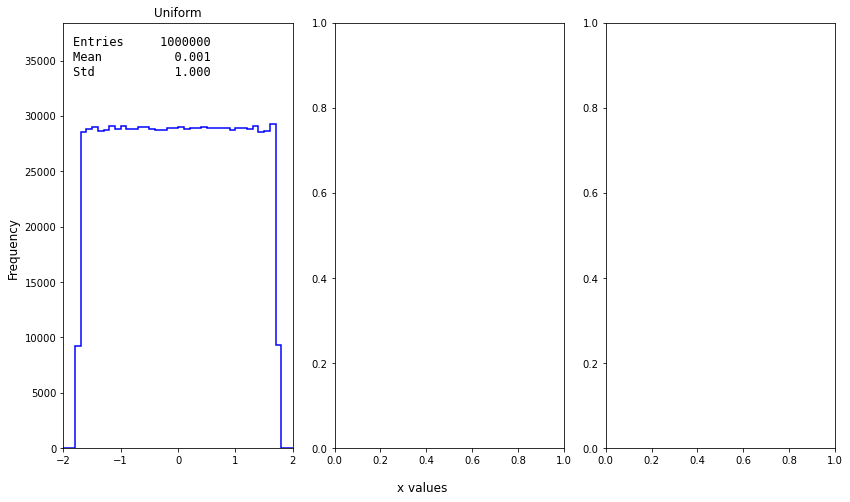

In [86]:
fig, axes = plt.subplots(1, 3, figsize = (12,7), facecolor = "white")

def plotsubplot(data, bins, xrange, ax, title):
    bins = (max(xrange)-min(xrange))*10
    if len(data) > 0:
        ax.hist(data, bins = bins, range = xrange, histtype='step', color = "b", linewidth = 1.5)
        ymax = ax.get_ylim()[1] * 1.25
        ax.set(title = title, xlim = xrange, ylim = (0, ymax))
        add_header_to_ax(data, 0.04, 0.97, ax)
        # Would be nice to write a function which automaticly placed the text in the center of the subplot
        
for dataset, xrange, ax, title in zip(x_flat, ranges, axes, titles):
    plotsubplot(dataset, N_bins, xrange, ax, title)

fig.supxlabel("x values")
fig.supylabel("Frequency")
    
fig.tight_layout()


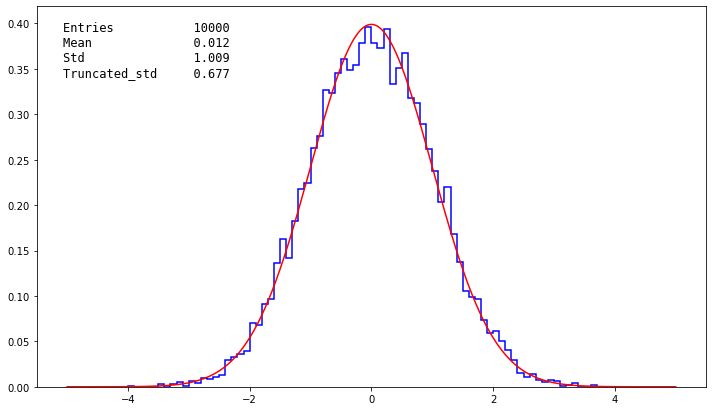

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (12,7), facecolor = "white")

histrange = (-5,5)
bin_per_sigma = 10
N_bins = (max(histrange) - min(histrange))*bin_per_sigma

ax.hist(x_sum, bins = N_bins, range = histrange, histtype= "step", density = True, color = "b", linewidth = 1.5)

add_header_to_ax(x_sum, 0.04, 0.96, ax, gettstd = True)

xline = np.linspace(*histrange, 10000)

def gausspdf(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)

ygauss = [gausspdf(x) for x in xline] #*N_experiments/bin_per_sigma

ax.plot(xline, ygauss, color = "r", linewidth = 1.5)
plt.show()

In [90]:
N_beyond3 = int(np.sum(np.logical_or((x_sum < -3),(x_sum > 3))))
print(f"Number of datapoints beyond 3sigma \t {N_beyond3:d} / {N_experiments:d} = {N_beyond3/N_experiments*100:6.4f}%")

N_beyond3_5 = int(np.sum(np.logical_or((x_sum < -3.5),(x_sum > 3.5))))
print(f"Number of datapoints beyond 3.5sigma \t {N_beyond3_5:d} / {N_experiments:d} = {N_beyond3_5/N_experiments*100:6.4f}%")

N_beyond4 = int(np.sum(np.logical_or((x_sum < -4),(x_sum > 4))))
print(f"Number of datapoints beyond 4sigma \t {N_beyond4:d} / {N_experiments:d} = {N_beyond4/N_experiments*100:6.4f}%")

Number of datapoints beyond 3sigma 	 28 / 10000 = 0.2800%
Number of datapoints beyond 3.5sigma 	 3 / 10000 = 0.0300%
Number of datapoints beyond 4sigma 	 0 / 10000 = 0.0000%


***
***

First make sure that you understand what the Central Limit Theorem (CLT) states! Then, acquaint yourself with the program. Make sure that you read through it, as many
of these features will be used onwards. Do you understand why the uniform distribution needs to go from $\pm \sqrt 3$ in order to give a distribution with a width of $1$ (i.e. unit) and why you subtract $1$ from the exponential distribution (and how this works at all)?

# Questions:

1. What is the mean and RMS of the input distributions?

The mean is 0 an RMS is 1 for uniform and exponential. RMS is undefined for cauchy

2. Why would one want to put a factor $\frac{1}{\sqrt N}$ when summing up the various contributions to sum?
    Hint: Assume that I always wanted to compare the distribution of sums with a UNIT Gaussian.

For a gaussian distribution the uncertianty on the mean falls of as $\frac{1}{\sqrt N}$. So by dividing the sum we get a constant std on the resulting gaussian distribution

3. Using a sum of 10 uniform random numbers with mean 0 and width 1, what is the expected 
    width of the resulting distribution according to CLT? What is the probability of
    obtaining a number beyond 3 sigma, i.e. how many numbers did you get beyond 3 sigma?
    What would you expect from a true Gaussian distribution?
    And what about the same question for 3.5 sigma? And 4.0 sigma?
    Put additional counters into the code, to test any effects in the tails (which have little statistics as it is).
    Increase the number of experiments run to (much) more than 1000...

for uniform it is about a std of 1. for 10 uniform numbers summed 10000 times I get; 3 $\!\sigma$ = 0.28%, 3.5 $\!\sigma$ = 0.03% and 4 $\!\sigma$ =  0%. The theoretical of a unit gaussian is 3 $\!\sigma$ = 0.27%, 3.5 $\!\sigma$ = 0.047% and 4 $\!\sigma$ = 0.00633%. Therefore, the expected value to get is 0.6 beyond  4 $\!\sigma$ so my findings are resonable, and is ingeneral in agreement with the theoretical percentages. 

4. Now try to add 10 exponential (i.e. set `N_exponential=10` and rerun the program). Does that give something Gaussian? What about 1000?
    Then try to add 10 cauchy numbers (i.e. set `N_cauchy=10` and rerun the program). Does that give something Gaussian? What about 1000?
    If not Gaussian, why do the Cauchy distribution "ruin" the Gaussian distribution?
    And is this in conflict with the Central Limit Theorem? 

Exponetial gives a somewhat gaussian with a negative skew

Cauchy ruins the gaussian distribution as it does not have a finite width.


### Advanced questions:

5. If one used a trunkated mean throwing away the top and bottom e.g. 10%,
    will the truncated mean of 1000 Cauchy numbers then converge to a Gaussian (possibly not with unit width)?

It does look a lot more like a gaussian, but even a truncated cauchy does not have a finite width and will never converge to a gaussian

6. What is the lowest number of uniform random numbers needs to be added, before the probability
    for the sum to follow a Gaussian distribution is greater than 1% (on average)
    when considering 1000 sums (i.e. `N_experiments=1000`)? Here, a $\chi^2$ fit is needed.



In [95]:
N_experiments = 1000                  # Number of sums produced
N_uniform     = 10                  # Number of uniform numbers used in sum
N_exponential = 0                     # Number of exponential numbers used in sum
N_cauchy      = 0  

N3_sigma = 0        # Counter for the number of produced sums, that fall outside +-3 sigma

x_uniform = np.zeros((N_uniform, N_experiments))
x_exponential = np.zeros((N_exponential, N_experiments))
x_cauchy = np.zeros((N_cauchy, N_experiments))
x_sum = np.zeros((N_experiments))

cau_trunc = 0.1

for iexp in range(N_experiments):
    
    x_uniform[:, iexp] = (np.random.uniform(size = N_uniform) - 0.5) * np.sqrt(12) 
    total_sum = np.sum(x_uniform[:, iexp])
    
    x_exponential[:, iexp] = (np.random.exponential(size = N_exponential) - 1)
    total_sum += np.sum(x_exponential[:, iexp])
    
    x_cauchy[:, iexp] = np.random.standard_cauchy(size = N_cauchy)
    if len(x_cauchy) > 0: 
        trunc_bool = np.logical_and(
            (x_cauchy[:, iexp] > np.percentile(x_cauchy[:, iexp], cau_trunc * 100)),
            (x_cauchy[:, iexp] < np.percentile(x_cauchy[:, iexp], (1 - cau_trunc) * 100))
            )
        total_sum += np.sum(x_cauchy[trunc_bool, iexp])
    else:
        total_sum += np.sum(x_cauchy[:, iexp])
    
    N_total = N_uniform + N_exponential + N_cauchy * (1 - 2*cau_trunc)
    x_sum[iexp] = total_sum / np.sqrt(N_total)
    


52.05505290505612


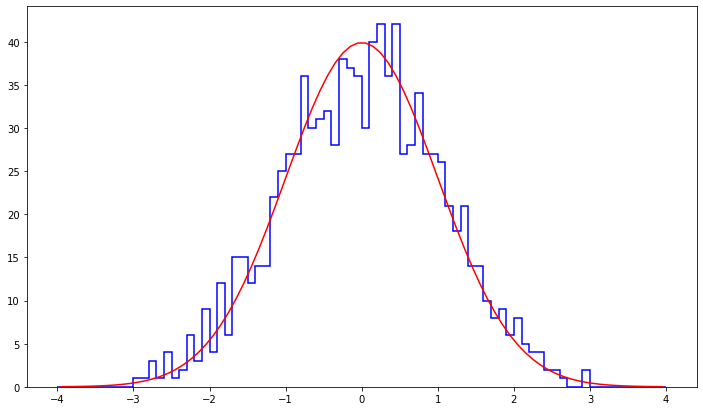

In [132]:
def chi2test(y, x, theofunc):
    fy = theofunc(x)
    std = 1
    chisqreg = (y - fy) ** 2 / std
    
from ExternalFunctions import Chi2Regression

count, interval = np.histogram(x_sum, bins=1000, range=(-4,4))
def inbetween(interval):
    interval = np.array(interval)
    return (interval[1:] + interval[:-1])/2

def chi2regbinned(f, x, bins = 1000, xrange = (-4,4)):
    count, interval = np.histogram(x, bins=bins, range=xrange)
    totalcount = np.sum(count)
    interval = inbetween(interval)
    xdis = (xrange[1] - xrange[0])/(bins)
    fy = [totalcount * xdis * f(x) for x in interval]
    fig, ax = plt.subplots(1, 1, figsize = (12,7), facecolor = "white")
    ax.hist(x, bins=bins, range=xrange, histtype= "step", color = "b", linewidth = 1.5)
    ax.plot(interval, fy, color = "r")
    chi2 = np.sum((count - fy)**2/fy)
    return chi2

print(chi2regbinned(gausspdf, x_sum, bins = 80))

#need to contribute the chi2 value to procent of the data coming from the given distribution
    
    

# Learning points:

The exercises should make you:
1. Understand why the Gaussian distribution is central in statistics (since all combinations of distributions converge towards it).
2. Give you a feel for how "fast" this convergence is (i.e. relatively fast for "nice" distributions).
3. Give you confidence in why we consider uncertainties Gaussian, unless known to be otherwise.

Including the Cauchy distribution was simply to make you think about how the Central Limit Theorem is stated!